## Part 4: Sentiment of the artists and communities

**The questions below are based on Lecture 8**

- Calculate the sentiment of the band/artist pages (it is OK to work with the sub-network of artists-with-genre) 

- Describe your findings using stats and visualization, inspired by the first exercise of week 8.

- Discuss the sentiment of the communities. Do the findings using TF-IDF during Lecture 7 help you understand your results?

---

In [73]:
# SETUP

# Import necessary libraries
import os
import pandas as pd
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from nltk import FreqDist
import networkx as nx
from collections import Counter
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# Prepare NLTK resources 
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)



True

### Calculating the sentiment of each artist page

- Start by donwloading the wordlist, and saving it locally as labmt_wordlist.txt
- In a dictionary of M words, each word was given a fixed happiness score (1 to 9) by workers in the Mechanical Turk platform.
    - 1 would be extremely negative, 5 neutral, and 9 extremely positive
    - Then the scores (around 50 ratings) are averaged to get the final score for each word.


In [75]:
# Skip the header lines and load the word list into a DataFrame
with open("labmt_wordlist.txt", "r") as f:
    word_list = f.readlines()
    
# Join the lines and skip the first 4 lines (metadata + header)
data_str = "".join(word_list[3:])
labmt_df = pd.read_csv(StringIO(data_str), sep="\t")

# Display the first few rows of the DataFrame
labmt_df.head()

# Create a dictionary for quick word → happiness lookup
labmt_dict = dict(zip(labmt_df["word"], labmt_df["happiness_average"]))
labmt_dict["happy"]  # Example

8.3

- Then, we need to create a function that takes as input a list of tokens, fetches each of theirs "happiness_average" (if found in the list), and calculates the average sentiment of the total text.

- As recommended, we use the **FreqDist** because it efficiently counts the frequency of each unique token, allowing us to compute weighted sentiment scores without repeatedly scanning the entire token list.

In [76]:
def calculate_sentiment(token, labmt_dict):
    """Calculate sentiment score for a list of tokens using labmt_df as reference."""
    
    # Create a dictionary from labmt_df for fast lookup
    score_dict = dict(zip(labmt_df['word'], labmt_df['happiness_average']))
    
    fd = FreqDist(tokens)  # Count unique tokens once
    sentiment_score = 0
    matched_tokens = 0

    for token, freq in fd.items():
        token_score = score_dict.get(token)
        if token_score is not None:  # Token exists in dictionary
            sentiment_score += token_score * freq
            matched_tokens += freq

    total_tokens = sum(fd.values())
    if matched_tokens == 0:
        print("No words matched in sentiment dictionary.")
        return None

    #percent_found = (matched_tokens / total_tokens) * 100
    #print(f"{percent_found:.2f}% of words were found in the sentiment dictionary.")

    average_sentiment = sentiment_score / matched_tokens
    return average_sentiment

# Test the function with some example tokens
test_tokens = ["happy", "joyful", "excited"]
print(calculate_sentiment(test_tokens, labmt_dict))  # Should print the average sentiment score

5.771957163958639


- Now, we load the stored network graph "new_rock_artists.graphml" and iterate over all nodes, to calculate the sentiment for each of their pages.

In [111]:
# Load graph and convert to undirected
G = nx.read_graphml("new_rock_artists.graphml")

G_und = G.to_undirected(reciprocal=False, as_view=False)

In [112]:
# Load the WordNet lemmatizer and stop words
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Iterate over nodes to load artist texts and calculate sentiment
print("Loading artist texts and calculating sentiment...")

for node in G_und.nodes():
    # open artist file
    folder_path="artist_texts"
    filename = node + ".txt" 
    file_path = os.path.join(folder_path, filename)
    with open(file_path, "r", encoding="utf-8") as f:
        node_text = f.read()

    wiki_terms = {
        'cite', 'ref', '/ref', 'category', 'infobox', 'stub', 'short', 'description', 'template',
        'file', 'image', 'external', 'links', 'references', 'see', 'also', 'edit', 'wikidata',
        'article', 'band', 'album', 'name', 'page', 'list', 'track', 'single', 'released', 'chart',
        'music', 'label', 'record', 'records', 'artist', 'group', 'song', 'songs', 'year', 'years',
        'date', 'title', 'awards', 'award', 'official', 'website', 'link', 'bio', 'history', 'http'}
    
    # Tokenize into words
    tokens = nltk.word_tokenize(node_text)
    
    # Remove punctuation and make lowercase
    tokens = [t.lower() for t in tokens if t.isalpha() and t.lower() not in stop_words]

    # Remove wiki terms that don't add relevant sentiment value
    tokens=[t for t in tokens if t not in wiki_terms]
    
    # Lemmatize - this increased the number of words found in the sentiment dictionary
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    
    # Count word frequencies
    counter = Counter(tokens)

    # Filter out rare words (less than 5 occurrences)
    counter = Counter({word: count for word, count in counter.items() if count >= 5})
    
    node_clean_text=counter
    
    # Calculate sentiment
    sentiment = calculate_sentiment(node_clean_text, labmt_dict)

    print(f"Artist: {node} | Sentiment: {sentiment}")

    # Store sentiment in graph
    G_und.nodes[node]["sentiment"] = sentiment


Loading artist texts and calculating sentiment...
Artist: 10 years (band) | Sentiment: 5.752886683209262
Artist: disturbed (band) | Sentiment: 5.5490350223546985
Artist: breaking benjamin | Sentiment: 5.617268014515291
Artist: mudvayne | Sentiment: 5.639165413533836
Artist: korn | Sentiment: 5.718133281371791
Artist: deftones | Sentiment: 5.769880736323565
Artist: stone temple pilots | Sentiment: 5.816760925449867
Artist: thousand foot krutch | Sentiment: 5.7857654185022
Artist: linkin park | Sentiment: 5.874559659090905
Artist: shinedown | Sentiment: 5.6554988028730975
Artist: puddle of mudd | Sentiment: 5.742865792129166
Artist: 10cc | Sentiment: 5.76270102452654
Artist: the yardbirds | Sentiment: 5.748781226343675
Artist: simon & garfunkel | Sentiment: 5.773161229014882
Artist: the hollies | Sentiment: 5.719291026276648
Artist: herman's hermits | Sentiment: 5.734013772749631
Artist: the beatles | Sentiment: 5.826729585556015
Artist: the moody blues | Sentiment: 5.767670909948137
Art

---

### Presenting our findings

- Histogram showing the sentiment distribution of the artist pages.
- The histogram shows the median and mean lines, as well as the 25th and 75th percentile.
- Finally the top 3 "happiest and saddest" artists are shown.

In [116]:
# Convert sentiments to a numpy array for analysis
sentiments = list(nx.get_node_attributes(G_und, "sentiment").values())
print(sentiments)
sentiments_array = np.array(sentiments)

# Calculate statistics
print(f"Number of artists with sentiment scores: {len(sentiments_array)}")
average_sentiment = np.mean(sentiments_array)
median_sentiment = np.median(sentiments_array)
mean_sentiment = np.mean(sentiments_array)
variance_sentiment = np.var(sentiments_array)
percentile_25 = np.percentile(sentiments_array, 25)
percentile_75 = np.percentile(sentiments_array, 75)

# Print statistics
print(f"\nAverage Sentiment: {average_sentiment}")
print(f"Median Sentiment: {median_sentiment}")
print(f"Mean Sentiment: {mean_sentiment}")
print(f"Variance of Sentiment: {variance_sentiment}")
print(f"25th Percentile of Sentiment: {percentile_25}")
print(f"75th Percentile of Sentiment: {percentile_75}")



[5.752886683209262, 5.5490350223546985, 5.617268014515291, 5.639165413533836, 5.718133281371791, 5.769880736323565, 5.816760925449867, 5.7857654185022, 5.874559659090905, 5.6554988028730975, 5.742865792129166, 5.76270102452654, 5.748781226343675, 5.773161229014882, 5.719291026276648, 5.734013772749631, 5.826729585556015, 5.767670909948137, 5.8074019771187455, 5.87854854854855, 5.833479909021984, 5.793763649962602, 5.796286849950311, 5.719741898480059, 5.789619771863132, 5.835610186092067, 5.673621419676218, 5.7643405343945355, 5.671544224262927, 5.851766864239341, 5.830430388569448, 5.883376825100965, 5.662834813499106, 5.774914196567852, 5.820397230320695, 5.781054766734269, 5.728333604556537, 5.6131017964071805, 5.7406712962962905, 5.6866365131579, 5.8013997352746545, 5.820855878012791, 5.815561027084058, 5.726167527251855, 5.747914893617019, 5.863799229717978, 5.827627669452195, 5.852887931034475, 5.846480203414451, 5.880643620650444, 5.787983425414353, 5.746667764241031, 5.83089887

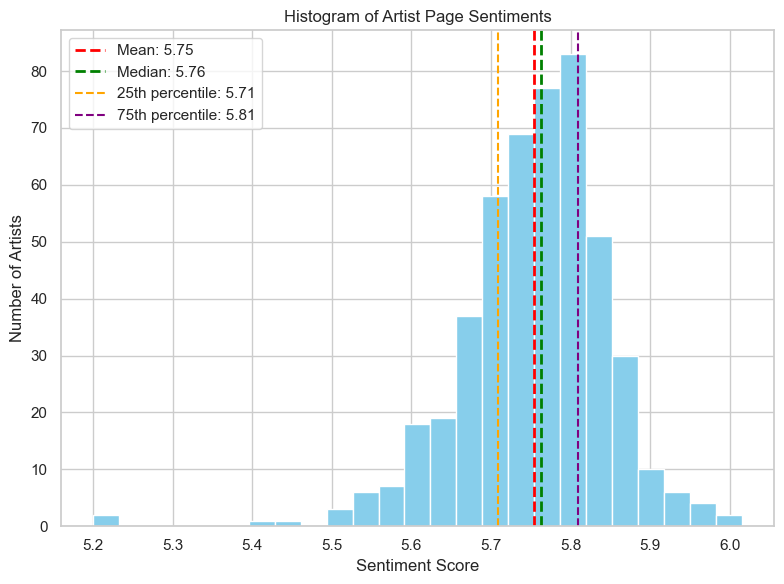

In [122]:
# Plot histogram 
sns.set(style="whitegrid")
plt.figure(figsize=(8,6))
plt.hist(sentiments_array, bins=25, color='skyblue')

# Lines for stats
plt.axvline(average_sentiment, color='red', linestyle='--', linewidth=2, label=f'Mean: {average_sentiment:.2f}')
plt.axvline(median_sentiment, color='green', linestyle='--', linewidth=2, label=f'Median: {median_sentiment:.2f}')
plt.axvline(percentile_25, color='orange', linestyle='--', linewidth=1.5, label=f'25th percentile: {percentile_25:.2f}')
plt.axvline(percentile_75, color='purple', linestyle='--', linewidth=1.5, label=f'75th percentile: {percentile_75:.2f}')

plt.xlabel('Sentiment Score')
plt.ylabel('Number of Artists')
plt.title('Histogram of Artist Page Sentiments')
plt.legend()
plt.tight_layout()
plt.show()


In [126]:
# Get top 3 happiest artists
top_happy = sorted(G_und.nodes(data=True), key=lambda x: x[1]["sentiment"], reverse=True)[:3]
print("Top 3 Happiest Artists:")
for i, (name, data) in enumerate(top_happy, 1):
    print(f"{i}. {name} - Sentiment: {data['sentiment']:.2f}")

print("-----------------")

# Get top 3 saddest artists
top_sad = sorted(G_und.nodes(data=True), key=lambda x: x[1]["sentiment"])[:3]
print("Top 3 Saddest Artists:")
for i, (name, data) in enumerate(top_sad, 1):
    print(f"{i}. {name} - Sentiment: {data['sentiment']:.2f}")

Top 3 Happiest Artists:
1. boys like girls - Sentiment: 6.02
2. fun (band) - Sentiment: 5.99
3. tracy chapman - Sentiment: 5.98
-----------------
Top 3 Saddest Artists:
1. the b-52's - Sentiment: 5.20
2. five finger death punch - Sentiment: 5.23
3. rob zombie - Sentiment: 5.42
